In [1]:
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt
import copy

# Functions

In [2]:
def compute_composites(dataarray, df_wr_season):
    # Initialize the dictionary to store composites
    Composites = {wr: {} for wr in df_wr_season['WR'].unique()}
    
    # List of seasons to loop through
    seasons = ['Winter', 'Spring', 'Summer', 'Fall', 'all']
    
    # Loop over each WR class
    for wr in df_wr_season['WR'].unique():
        # Loop over each season including the 'all' category
        for season in seasons:
            if season == 'all':
                # Select dates corresponding to the current WR class, regardless of season
                indices = df_wr_season.index[df_wr_season['WR'] == wr]
            else:
                # Select dates corresponding to the current WR class and season
                indices = df_wr_season.index[(df_wr_season['WR'] == wr) & (df_wr_season['season'] == season)]
            
            # Convert indices to datetime format
            indices = pd.to_datetime(indices)
            
            # Select the data corresponding to the chosen dates
            selected_data = dataarray.sel(time=indices)
            
            # Compute the average over the selected times
            composite_mean = selected_data.mean(dim='time')
            
            # Store the composite in the dictionary
            Composites[wr][season] = composite_mean
    
    return Composites

In [3]:
def compute_composites_sum(dataarray, df_wr_season):
    # Initialize the dictionary to store composites
    Composites = {wr: {} for wr in df_wr_season['WR'].unique()}
    
    # List of seasons to loop through
    seasons = ['Winter', 'Spring', 'Summer', 'Fall', 'all']
    
    # Loop over each WR class
    for wr in df_wr_season['WR'].unique():
        # Loop over each season including the 'all' category
        for season in seasons:
            if season == 'all':
                # Select dates corresponding to the current WR class, regardless of season
                indices = df_wr_season.index[df_wr_season['WR'] == wr]
            else:
                # Select dates corresponding to the current WR class and season
                indices = df_wr_season.index[(df_wr_season['WR'] == wr) & (df_wr_season['season'] == season)]
            
            # Convert indices to datetime format
            indices = pd.to_datetime(indices)
            
            # Select the data corresponding to the chosen dates
            selected_data = dataarray.sel(time=indices)
            
            # Compute the average over the selected times
            composite_mean = selected_data.sum(dim='time')
            
            # Store the composite in the dictionary
            Composites[wr][season] = composite_mean
    
    return Composites

In [4]:
def dictionary_to_dataset(composites_dict):
    # Create an empty dataset
    ds = xr.Dataset()
    
    # Iterate through the dictionary and add each DataArray to the dataset
    for wr, seasons in composites_dict.items():
        for season, da in seasons.items():
            # Create a unique name for each DataArray based on WR and season
            var_name = f"{wr}_{season}"
            ds[var_name] = da
    
    return ds

In [5]:
# Convert the dataset back to a dictionary structure
def dataset_to_dictionary(ds):
    composites_dict = {}
    for var in ds.data_vars:
        wr, season = var.split('_')
        if wr not in composites_dict:
            composites_dict[wr] = {}
        composites_dict[wr][season] = ds[var]
    return composites_dict


In [15]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_composites(Composites, quantity_name, vmin, vmax, units,colormap,pathsave=None,multiply = 1):
    # Define the color levels and color map
    levels = np.linspace(vmin, vmax, 11)
    cmap = plt.get_cmap(colormap)

    # Create the figure and axes
    fig, axes = plt.subplots(nrows=len(Composites), ncols=5, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
    axes = axes.flatten()

    names_wrs = ["Pacific High","Pacific Trough","Greenland High","Atlantic High","No WR"]
    season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']

    # Iterate over each weather regime (rows)
    for wr in range(len(Composites)):
        # Iterate over each season (columns)
        for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'all']):
            ax = axes[wr * 5 + iseason]

            # Plot the composite map
            try:
                composite = Composites[str(wr)][season]
            except:
                composite = Composites[wr][season]
            # Convert longitudes to -180 to 180 range
            lon = (composite.lon + 180) % 360 - 180
            ax.set_extent([-80, 50, 20, 75], crs=ccrs.PlateCarree(central_longitude=-100))

            # cf = ax.contourf(lon, composite['lat'], composite * multiply, levels=levels, 
            #                  cmap=cmap, transform=ccrs.PlateCarree(), extend='both')
            cf = ax.pcolormesh(lon, composite['lat'], composite * multiply, vmin=vmin,vmax=vmax, 
                             cmap=cmap, transform=ccrs.PlateCarree())
            
            # Add coastlines and gridlines
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, alpha=0.7)

            # Ensure y-ticks are present for the first column
            if iseason == 0:
                ax.set_yticks([])  # Example y-ticks, adjust as needed
                ax.set_ylabel(f'{names_wrs[wr]}', fontsize=13)
            else:
                ax.set_yticklabels([])  # Remove y-tick labels for other columns

            # Set the title for each season column (first row only)
            if wr == 0:
                ax.set_title(season_titles[iseason], fontsize=13)

            # Set font sizes for axes labels
            ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a main title to the entire plot
    fig.suptitle(f"{quantity_name} - Composites", fontsize=18, y=0.96, 
                 horizontalalignment = 'left', x=0.)

    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Create colorbar
    cbar_ax = fig.add_axes([0.8, 0.95, 0.2, 0.01])  # Position similar to the legend
    cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(units, fontsize=13)
    cbar.ax.tick_params(labelsize=10)
    if pathsave:
        plt.savefig(pathsave,bbox_inches='tight')
    else:
        plt.show()

In [7]:
import xarray as xr

def compute_seasonal_averages(dataarray):
    """
    Compute the seasonal and overall 2D averages from a DataArray.

    Parameters:
    dataarray (xr.DataArray): The input DataArray with a 'time' dimension.

    Returns:
    dict: A dictionary with keys 'Winter', 'Spring', 'Summer', 'Fall', and 'all',
          each containing the corresponding 2D average as a DataArray.
    """
    # Create a dictionary to store the seasonal averages
    seasonal_averages = {}

    # Define seasons and the corresponding months
    seasons = {
        'Winter': [12, 1, 2],
        'Spring': [3, 4, 5],
        'Summer': [6, 7, 8],
        'Fall': [9, 10, 11],
        'all': None  # 'all' will include all months
    }

    # Calculate seasonal averages
    for season, months in seasons.items():
        if season == 'all':
            # Calculate the average over the entire time period
            seasonal_averages[season] = dataarray.mean('time')
        else:
            # Select data corresponding to the season months
            season_data = dataarray.where(dataarray['time.month'].isin(months), drop=True)
            
            # Calculate the average for the selected season
            seasonal_averages[season] = season_data.mean('time')

    return seasonal_averages

In [8]:
import xarray as xr

def compute_seasonal_sums(dataarray):
    """
    Compute the seasonal and overall 2D averages from a DataArray.

    Parameters:
    dataarray (xr.DataArray): The input DataArray with a 'time' dimension.

    Returns:
    dict: A dictionary with keys 'Winter', 'Spring', 'Summer', 'Fall', and 'all',
          each containing the corresponding 2D average as a DataArray.
    """
    # Create a dictionary to store the seasonal averages
    seasonal_averages = {}

    # Define seasons and the corresponding months
    seasons = {
        'Winter': [12, 1, 2],
        'Spring': [3, 4, 5],
        'Summer': [6, 7, 8],
        'Fall': [9, 10, 11],
        'all': None  # 'all' will include all months
    }

    # Calculate seasonal averages
    for season, months in seasons.items():
        if season == 'all':
            # Calculate the average over the entire time period
            seasonal_averages[season] = dataarray.sum('time')
        else:
            # Select data corresponding to the season months
            season_data = dataarray.where(dataarray['time.month'].isin(months), drop=True)
            
            # Calculate the average for the selected season
            seasonal_averages[season] = season_data.sum('time')

    return seasonal_averages

In [9]:
def subtract_climatology_composites(composites_dict,climatology,normalize=True):
    composites_anoms_dict = copy.deepcopy(composites_dict)
    # Iterate through the dictionary and add each DataArray to the dataset
    for wr, seasons in composites_dict.items():
        for season, da in seasons.items():
            if normalize==True:
                composites_anoms_dict[wr][season] = (composites_dict[wr][season] - climatology[season])/climatology[season]
            else:
                composites_anoms_dict[wr][season] = (composites_dict[wr][season] - climatology[season])
    return composites_anoms_dict

In [10]:
import xarray as xr

def compute_max_precip_for_events(events_df, daily_precip_da):
    # Initialize a list to store the results
    max_precip_list = []
    times_list = []
    
    # Loop over each event in the DataFrame
    for index, row in events_df.iterrows():
        start_date = index  # start_date is the index of the DataFrame
        duration = row['duration']
        end_date = start_date + pd.Timedelta(days=duration)
        
        # Select the time range in the DataArray
        precip_subset = daily_precip_da.sel(time=slice(start_date, end_date))
        
        # Compute the maximum value along the time dimension
        max_precip = precip_subset.max(dim='time')
        
        # Store the result in the list
        max_precip_list.append(max_precip)
        times_list.append(start_date)
    
    # Combine all the max_precip arrays into a single DataArray
    max_precip_da = xr.concat(max_precip_list, dim='time')
    max_precip_da.coords['time'] = times_list
    
    return max_precip_da

In [11]:
import xarray as xr

def compute_min_precip_for_events(events_df, daily_precip_da):
    # Initialize a list to store the results
    max_precip_list = []
    times_list = []
    
    # Loop over each event in the DataFrame
    for index, row in events_df.iterrows():
        start_date = index  # start_date is the index of the DataFrame
        duration = row['duration']
        end_date = start_date + pd.Timedelta(days=duration)
        
        # Select the time range in the DataArray
        precip_subset = daily_precip_da.sel(time=slice(start_date, end_date))
        
        # Compute the maximum value along the time dimension
        max_precip = precip_subset.min(dim='time')
        
        # Store the result in the list
        max_precip_list.append(max_precip)
        times_list.append(start_date)
    
    # Combine all the max_precip arrays into a single DataArray
    max_precip_da = xr.concat(max_precip_list, dim='time')
    max_precip_da.coords['time'] = times_list
    
    return max_precip_da

# Load data

In [12]:
temp_anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/TMean_ERA5_DailyAnoms_std.nc')
temp_anoms = temp_anoms.MeanTemp.compute()

In [13]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../Data_v4/Labels/df_labels_{reanalysis}_v4.csv', parse_dates=True, index_col=0, names=['WR','distance'], skiprows=1)
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    dic_labels[reanalysis] = labels_temp


dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    dic_events[reanalysis] = df_events

# Mean anomalies for each weather regime and season in standard deviations

In [14]:
composites_temp_std = compute_composites(temp_anoms, dic_labels['ERA5'])
composites_temp_std_ds = dictionary_to_dataset(composites_temp_std)
composites_temp_std_ds.to_netcdf('../Data_v4/CompositesTemperature/CompositesAnomaliesStd.nc')

In [16]:
# Load the dataset from the NetCDF file
composites_temp_std_ds = xr.open_dataset('../Data_v4/CompositesTemperature/CompositesAnomaliesStd.nc')
composites_temp_std = dataset_to_dictionary(composites_temp_std_ds)

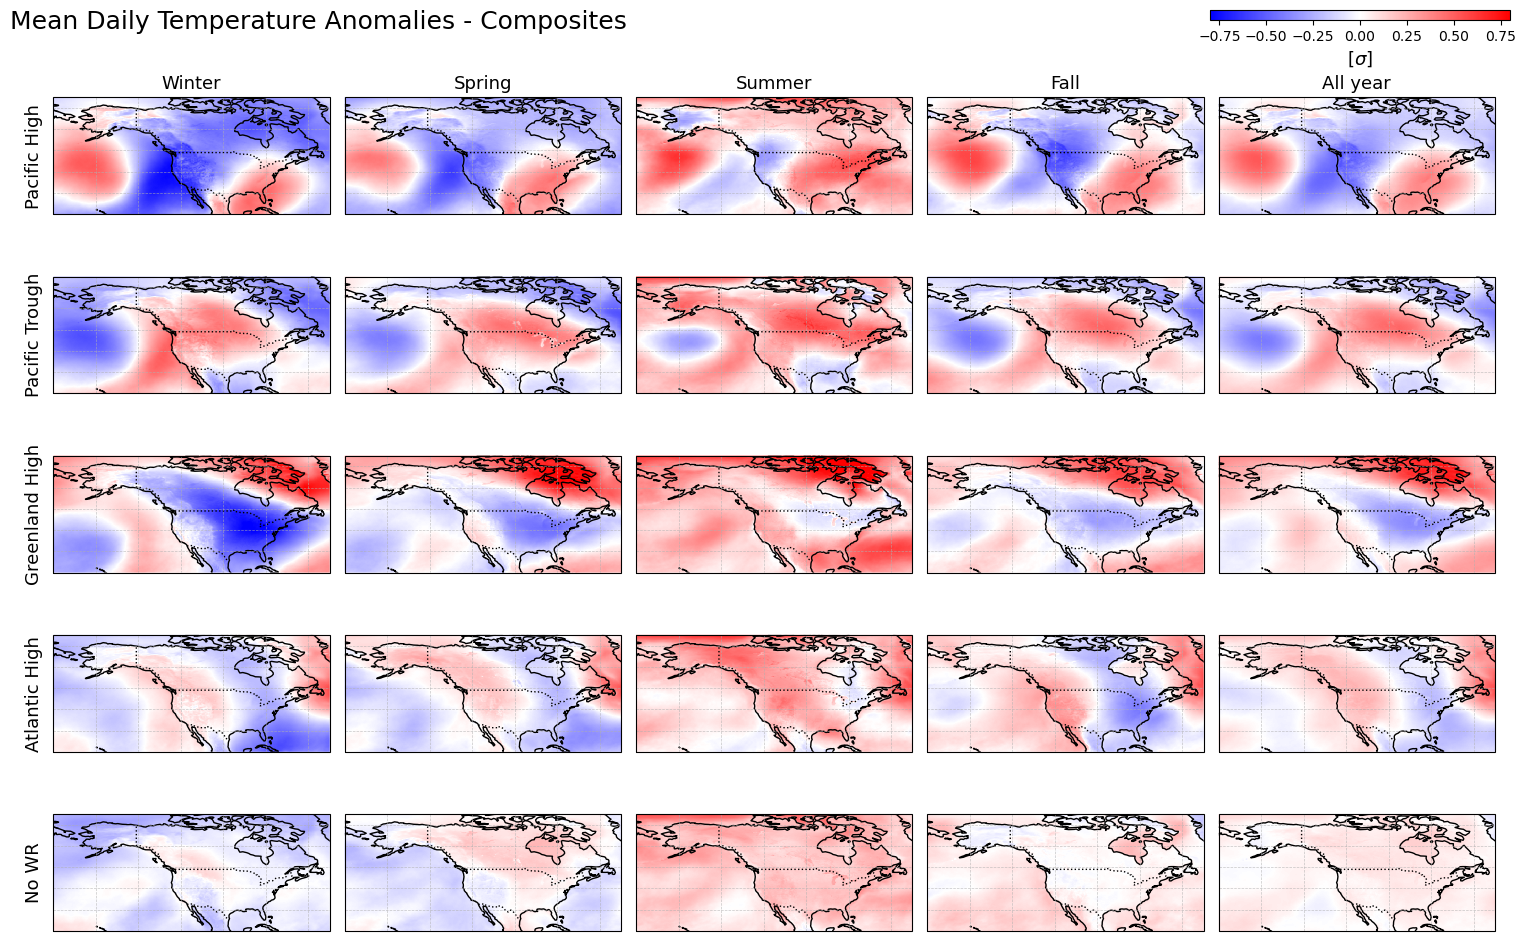

In [17]:
plot_composites(composites_temp_std, "Mean Daily Temperature Anomalies", 
                vmin=-0.8, vmax=0.8, 
                units=r'[$\sigma$]',colormap='bwr',
                pathsave='../Figures_v4/Temperature/Composites_TempAnomsStd.png')